In [1]:
import pandas as pd
import sklearn
import os

from lightgbm import LGBMRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [11]:
import sys
sys.path.append("../")

In [13]:

from preprocessing.utils import normalize_str, scale
from metrics.regression_metrics import get_regression_metrics


ModuleNotFoundError: No module named 'preprocessing'

# Global

In [7]:
RESULTS = pd.DataFrame()

# Data

In [8]:
df = pd.read_csv('../../../data/raw/train_data.csv')

In [9]:
label = 'y'

In [10]:
df.head(2)

,x1,x2,x3,y
0,9.262865,0.000793,0,-299.270637
1,-5.285342,0.000076,1,-160.034460


In [11]:
df[label].describe()

count    100000.000000
mean         64.082292
std         504.148338
min       -2459.738984
25%        -276.227996
50%          65.009221
75%         405.198476
max        2326.356392
Name: y, dtype: float64

# Transformation

In [12]:
X = df.drop([label], axis=1)
y = df[label]

In [13]:
# # Remove outliers
# between = df[(df[label]>=df[label].quantile(.25)) & (df[label]<= df[label].quantile(.75))]

# X = between.drop([label], axis=1)
# y = between[label]

In [14]:
# # Scale features and label
# x_scaled = scale(df.drop(label, axis=1))
# y_scaled = scale(df[label])

# X = x_scaled
# y = y_scaled

In [15]:
# # Scale between
# between_x_scaled = scale(between.drop(label, axis=1))
# between_y_scaled = scale(between[label])

# X = between_x_scaled
# y = between_y_scaled[label]

In [16]:
X.columns = [normalize_str(col) for col in X.columns]

# Metrics

In [17]:
score_metrics, refit_metric = get_regression_metrics()

# Model

In [18]:
steps=[('LGBMRegressor', LGBMRegressor())]

training_params = {
    'LGBMRegressor__n_estimators':[1000], 
    'LGBMRegressor__learning_rate':[0.001], 
    'LGBMRegressor__verbose':[-1], 
#     'LGBMRegressor__is_unbalance':[True],
    'LGBMRegressor__random_state':[2000]
}

In [19]:
def train_model(steps, training_params, X, y, desc):
    pipe = Pipeline(steps=steps)

    kfold = KFold(n_splits=5, shuffle=True, random_state=2000)

    grid = GridSearchCV(pipe,
                        param_grid=training_params,
                        verbose=True,
                        cv=kfold,
                        return_train_score=False,
                        scoring=score_metrics,
                        refit=refit_metric,
                        iid=True)

    grid.fit(X, y)
    print("Best parameter (CV score=%0.3f):" % grid.best_score_)

    results_now = pd.DataFrame(grid.cv_results_, index=[desc])
    results = pd.concat([RESULTS, results_now])
    
    return results, grid

In [20]:
RESULTS, grid = train_model(steps, training_params, X, y, 'between_scaled')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished


Best parameter (CV score=0.018):


In [21]:
grid.cv_results_

GridSearchCV(cv=KFold(n_splits=5, random_state=2000, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('LGBMRegressor',
                                        LGBMRegressor(boosting_type='gbdt',
                                                      class_weight=None,
                                                      colsample_bytree=1.0,
                                                      importance_type='split',
                                                      learning_rate=0.1,
                                                      max_depth=-1,
                                                      min_child_samples=20,
                                                      min_child_weight=0.001,
                                                      min_split_gain=0.0,
                                                      n_esti...
                      'quantile_error_25': make

In [22]:
RESULTS[[col for col in RESULTS.columns if 'mean_test_' in col]].T

,between_scaled
mean_test_median_absolute_error,-337.985166
mean_test_mean_absolute_error,-398.416818
mean_test_mean_squared_error,-249532.208338
mean_test_explained_variance,0.018263
mean_test_r2,0.018131
mean_test_max_error,-2207.235290
mean_test_min_error,-0.035956
mean_test_quantile_error_75,-574.737200
mean_test_quantile_error_25,-158.867056
mean_test_quantile_error_95,-979.858042


### > Plot Probability Distribution

In [23]:
errors = pd.read_csv('errors_reg.csv', index_col=0)

FileNotFoundError: [Errno 2] File b'errors_reg.csv' does not exist: b'errors_reg.csv'

In [ ]:
pd.concat([errors['y_true'].describe(), errors['y_pred'].describe()], axis=1)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.distplot(pd.Series(errors['y_pred']), bins=20)
sns.distplot(pd.Series(errors['y_true']), bins=20)
plt.legend(['y_pred', 'y_true'])
plt.show()

Text(0, 0.5, 'y_true')

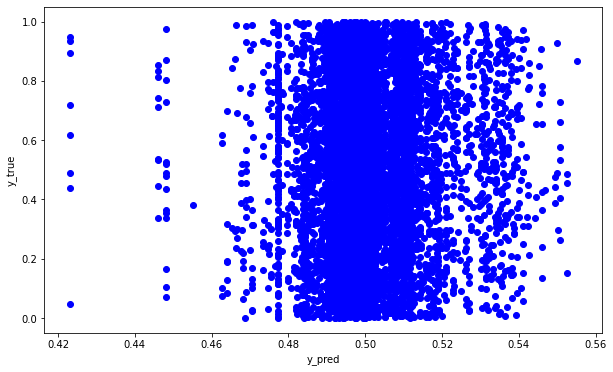

In [200]:
plt.figure(figsize=(10,6))
plt.plot(errors['y_pred'], errors['y_true'], 'bo', )
plt.xlabel('y_pred')
plt.ylabel('y_true')
# plt.plot(range(0, int(max(errors['y_pred']))), range(0, int(max(errors['y_true']))), color='red')